In [3]:
# ! unzip -q '/content/drive/MyDrive/Colab Notebooks/Datasets/Landscape color and grayscale images.zip' -d './'

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Imports
import os

import torch
import torchvision
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

In [43]:
# Data

MANUAL_SEED = 42
BATCH_SIZE = 100
SHUFFLE = True

In [44]:
# Create dataset to load the images
class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        self.dataroot = '/content/drive/MyDrive/dataset'
        self.images = []
        for root, _, files in os.walk(f'{self.dataroot}/color'):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Add more extensions if needed
                    self.images.append(os.path.join(root, file))

        if not self.images:  # Check if self.images is empty
            raise ValueError(f"No images found in {self.dataroot}/color. Check the directory path and ensure it contains images.")

        self.transform = transform

        if not self.images:  # Check if self.images is empty
            raise ValueError(f"No images found in {self.dataroot}/color. Check the directory path and ensure it contains images.")

        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image Paths
        img_path = self.images[idx]
        #print(f"Color image path: {img_path}")  # Print color image path

        # Load the images
        color_img = read_image(img_path) / 255
        # Extract filename from img_path and construct the gray image path
        gray_img_path = os.path.join(f'{self.dataroot}/gray', os.path.basename(img_path))
        #print(f"Grayscale image path: {gray_img_path}")  # Print grayscale image path
        if os.path.exists(gray_img_path):
          gray_img = read_image(gray_img_path) / 255
          if self.transform:
            color_img = self.transform(color_img)
            gray_img = self.transform(gray_img)

          return color_img, gray_img
        else:
            print(f"Skipping missing grayscale image: {gray_img_path}")
            # Skip this image by recursively calling __getitem__ with the next index
            # This assumes that the dataset is large enough that skipping a few images won't significantly affect training.
            # If the dataset is small, you might consider other strategies like replacing the missing image with a default value.
            return self.__getitem__((idx + 1) % len(self))



In [45]:
transform = transforms.Compose([
    transforms.Resize((150, 150), antialias=False),
    transforms.RandomHorizontalFlip(),  # Flip image horizontally with 50% probability
    transforms.RandomRotation(10),
])
# Load the dataset
dataset = LandscapeDataset(transform=transform)
print(f"Dataset length: {len(dataset)}")
# Split the data into train and test data
train_set, test_set = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(MANUAL_SEED))

# Load the train and set data
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

Dataset length: 501


In [46]:
# Visualize some images
def show_images(color, gray):
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    for i in range(5):
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 1].axis('off')
    plt.show()

In [47]:
#color, gray = next(iter(trainloader))
#show_images(color, gray)

In [48]:
# Training Variables

EPOCHS = 2
LEARNING_RATE = 0.001
MOMENTUM = 0.9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [49]:
# # Create the autoencoder model
# class ColorAutoEncoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # Input shape: Bx1x150x150
#         # Conv2d(in_channels, out_channels, kernel_size, stride, padding)


#         self.downsample = nn.Sequential(
#             nn.Conv2d(1, 64, 3, stride=2), # Bx64x74x74
#             nn.ReLU(),

#             nn.Conv2d(64, 128, 3, stride=2), # Bx128x36x36
#             nn.ReLU(),

#             nn.Conv2d(128, 256, 3, stride=2), # Bx256x17x17
#             nn.ReLU(),

#             nn.Conv2d(256, 512, 3, stride=2), # Bx512x8x8
#             nn.ReLU(),
#         )

#         self.upsample = nn.Sequential(
#             nn.ConvTranspose2d(512, 256, 3, stride=2),
#             nn.ReLU(),

#             nn.ConvTranspose2d(256, 128, 3, stride=2,  output_padding=1),
#             nn.ReLU(),

#             nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=1),
#             nn.ReLU(),

#             nn.ConvTranspose2d(64, 3, 3, stride=2, output_padding=1),
#             nn.ReLU(),

#         )

#     def forward(self, x):
#         x = self.downsample(x)
#         x = self.upsample(x)
#         return x

In [50]:
# Create the autoencoder model
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Input shape: Bx1x150x150
        # Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.down1 = nn.Conv2d(1, 64, 3, stride=2) # Bx64x74x74
        self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # Bx128x37x37
        self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1) # Bx256x19x29
        self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1) # Bx512x10x10

        self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(128, 3, 3, stride=2, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Down sample
        d1 = self.relu(self.down1(x))
        d2 = self.relu(self.down2(d1))
        d3 = self.relu(self.down3(d2))
        d4 = self.relu(self.down4(d3))
        # Upsample
        u1 = self.relu(self.up1(d4))
        u2 = self.relu(self.up2(torch.cat((u1,d3), dim=1)))
        u3 = self.relu(self.up3(torch.cat((u2, d2), dim=1)))
        u4 = self.sigmoid(self.up4(torch.cat((u3,d1), dim=1)))

        return u4

In [51]:
# Initialize the model
model = ColorAutoEncoder().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
f"Total Number of trainable parameters of this model are: {total_params:,}"

'Total Number of trainable parameters of this model are: 3,470,659'

In [52]:
# Initialize the optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [53]:
# Define the training loop
import os
for epoch in range(EPOCHS):
    running_loss = 0.0
    for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        # Make model predictions
        predictions = model(gray_img)

        optimizer.zero_grad()
        # Calculate loss between coloured image and predicted image
        loss = criterion(color_img, predictions)

        # Calcuate gradients and back propagate
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch: {epoch + 1}, Loss: {running_loss:.6f}')

print('Training Finished!')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.448128


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.426080
Training Finished!


In [54]:
# Test on testing data
total_loss = 0.0
with torch.no_grad():
    for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        prediction = model(gray_img)

        loss = criterion(prediction, color_img)
        total_loss += loss.item()

f"Total Testing loss is: {total_loss/ len(testloader):.3f}"

  0%|          | 0/1 [00:00<?, ?it/s]

'Total Testing loss is: 0.072'

In [55]:
# Visualize some predictions
def show_predictions(color, gray, pred):
    fig, axs = plt.subplots(5, 3, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    axs[0, 2].set_title('Predicted')
    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 2].axis('off')
        axs[i, 2].imshow(pred[i].permute(1,2,0))
    plt.show()


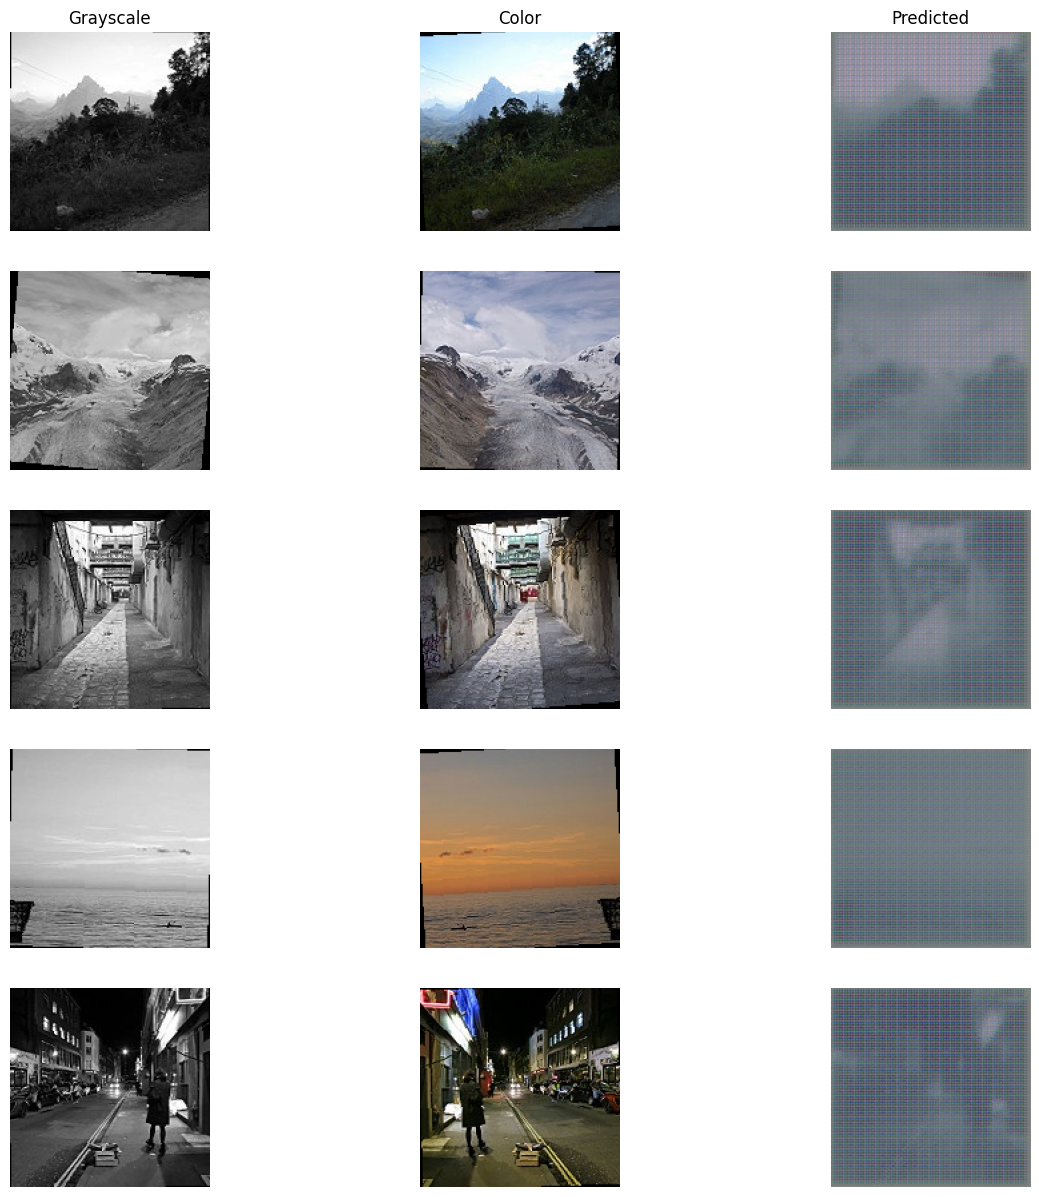

In [56]:
show_predictions(color_img.detach().cpu(), gray_img.detach().cpu(), prediction.detach().cpu())

Saving WhatsApp Image 2025-03-25 at 11.25.39 PM.jpeg to WhatsApp Image 2025-03-25 at 11.25.39 PM (1).jpeg


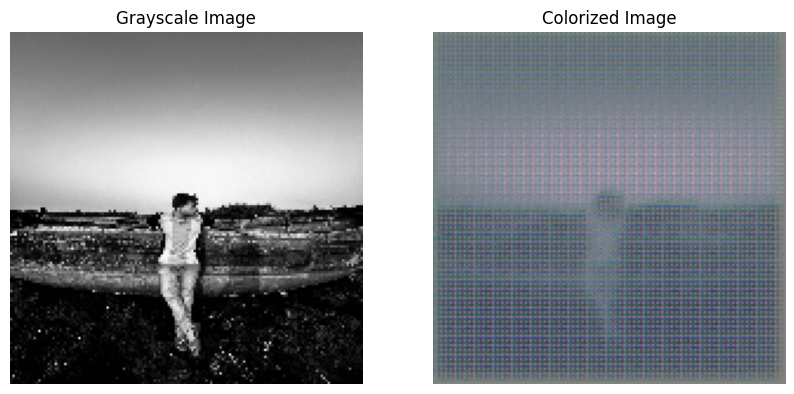

In [58]:
from google.colab import files
import matplotlib.pyplot as plt

def colorize_image():
    """
    Allows the user to upload a grayscale image, colorizes it using the trained model,
    and displays the original and colorized images.
    """

    # Get user input (grayscale image)
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]

    # Load and preprocess the image
    gray_img = read_image(image_path) / 255  # Load and normalize
    # Convert the image to grayscale explicitly
    gray_img = transforms.Grayscale(num_output_channels=1)(gray_img.float())
    gray_img = gray_img.unsqueeze(0).to(DEVICE)  # Add batch dimension and move to device
    gray_img = transforms.Resize((150, 150), antialias=False)(gray_img)  # Resize

    # Make prediction with the model
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        prediction = model(gray_img)

    # Display original and colorized images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(gray_img[0].cpu().permute(1, 2, 0), cmap='gray')  # Original grayscale
    plt.title('Grayscale Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction[0].cpu().permute(1, 2, 0))  # Colorized image
    plt.title('Colorized Image')
    plt.axis('off')

    plt.show()

# Call the function to start the colorization process
colorize_image()